## Comparison of CNN Models for Mass Detection in Mammography Images

### Setup

First we install any necessary packages.

In [1]:
!pip install pydicom
!pip install livelossplot

print('Installed packages.')

Installed packages.


Then we load the packages.

In [1]:
import os
import pydicom
import cv2
import plistlib
import random
import livelossplot
import time
import numpy as np
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf
import pandas as pd

from tqdm import tqdm
from sklearn import preprocessing
from skimage import transform
from sklearn.feature_extraction import image
from sklearn.utils import shuffle
from skimage.draw import polygon
from skimage.util import view_as_blocks
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
from keras.applications import vgg19, resnet_v2, nasnet, densenet, mobilenet_v2, inception_v3, xception

print('Loaded packages.')

Using TensorFlow backend.


Loaded packages.


Here's some shared code for the pre-processing and train/evaluation steps.

In [2]:
patch_size = (224,224)
input_shape = patch_size + (3,)

print('Defined input shape.')

Defined input shape.


In [3]:
def make_conv_base(model):
  return model(weights='imagenet', include_top=False, input_shape=input_shape)

print('Loaded convolutional bases.')

Loaded convolutional bases.


In [4]:
class TimeHistory(K.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

BATCH_SIZE = 64
EPOCHS = 100
plot_losses = livelossplot.PlotLossesKeras()
es = K.callbacks.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = K.callbacks.callbacks.ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
scoring_encoding = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4a': 4,
    '4b': 5,
    '4c': 6,
    '5': 7,
    '6': 8
}

def evaluate_model(model, x_test, y_test):
  beginning_time = time.time()
  y_pred = model.predict(x_test)
  ending_time = time.time()
  evaluation = model.evaluate(x_test, y_test)
  return y_pred, evaluation, ending_time-beginning_time

print('Defined training utilities.')

Defined training utilities.


## Pre-processing
Patch extraction and zero mean normalization. We write to a Google Drive to store the data and labels, so this section doesn't need to be run unless you need to perform pre-processing again. If you're satisfied with the Google Drive contents, you can proceed to the next section.

We load the [INBreast](https://github.com/wentaozhu/deep-mil-for-whole-mammogram-classification/issues/12) dataset from Dropbox.

In [13]:
!wget -O inbreast https://www.dropbox.com/sh/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa?dl=0 inbreast
!unzip inbreast -d /inbreast

print('Loaded INBreast.')

--2020-05-05 17:47:26--  https://www.dropbox.com/sh/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa [following]
--2020-05-05 17:47:27--  https://www.dropbox.com/sh/raw/k0e06yayf50kspe/AADmoROCuzfffA6EhRKSqghGa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb04843a193e802d981e07cc38e.dl.dropboxusercontent.com/zip_download_get/Aajz7jJGlN_NwpFsJGiPveZrl5T1svC7AjEkKbYU1ZiI2yPunOj35EVQGvpRQVZAOmNc8pre3UEYZd3E493Z4lNLKa7-FDRVUwwC_l5zv1y4fQ [following]
--2020-05-05 17:47:34--  https://ucb04843a193e802d981e07cc38e.dl.dropboxusercontent.com/zip_download_get/Aajz7jJGlN_NwpFsJGiPveZrl5T1svC7AjEkKbYU1ZiI2yPunOj35EVQGvpRQVZAOmNc8pre3UEYZd3E493Z

This is a utility for loading INBreast ROIs.

In [3]:
df_inbreast = pd.read_csv('../inbreast/INbreast.csv', sep=";")

patient_scores = {}
for i, filename in enumerate(df_inbreast['File Name']):
  patient_scores[str(filename)] = scoring_encoding[df_inbreast['Bi-Rads'][i]]

print('Loaded patient Bi-Rads scores.')

Loaded patient Bi-Rads scores.


In [14]:
def load_inbreast_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """
    result = []
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            mask = np.zeros(imshape)
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            assert numPoints == len(points)
            points = [eval(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[1]), int(point[0])] = 1
            else:
                x, y = zip(*points)
                col, row = np.array(x), np.array(y) ##x coord is the column coord in an image and y is the row
                poly_x, poly_y = polygon(row, col, shape=imshape)
                mask[poly_x, poly_y] = 1
            # store indices for nonzero points so that patches containing tumors
            # can be extracted
            locations_of_interest = np.nonzero(mask)
            coords = np.array(locations_of_interest).T
            # x_coords, y_coords = np.nonzero(mask)
            # x_min = np.min(x_coords)
            # x_max = np.max(x_coords)
            # y_min = np.min(y_coords)
            # y_max = np.max(y_coords)
            # if x_min == x_max:
            #   x_min -= 5
            #   x_max += 5
            # if y_min == y_max:
            #   y_min -= 5
            #   y_max += 5
            # bounding_box = (x_min, x_max, y_min, y_max)
            # result.append(bounding_box)
    return coords

print('Defined INBreast ROI loading utility.')

Defined INBreast ROI loading utility.


Then we load the INBreast ROIs.

In [15]:
inbreast_xml = '../inbreast/xml'
inbreast_rois = {}

files = os.listdir(inbreast_xml)
with tqdm(total=len(files)) as t:
  for filename in files:
    coords = load_inbreast_mask(os.path.join(inbreast_xml, filename))
    inbreast_rois[filename.split('.')[0]] = coords
    t.update()

print('Finished loading ROIs.')

100%|██████████| 343/343 [31:10<00:00,  5.45s/it]

Finished loading ROIs.


We extract patches from the input as a pre-processing step, following [Agarwal et al.](https://www.spiedigitallibrary.org/journals/journal-of-medical-imaging/volume-6/issue-03/031409/Automatic-mass-detection-in-mammograms-using-deep-convolutional-neural-networks/10.1117/1.JMI.6.3.031409.full?SSO=1) This is also where data augmentation of positive examples, through horizontal flipping and random rotation, and zero mean normalization occurs.

In [41]:
inbreast_dicom = '../inbreast/dicom'
display = False
N = 3000

X = np.zeros((N,)+input_shape)
Y = np.zeros((N,))
Y_multiclass = np.zeros((N,))

n = 0
dicom_files = os.listdir(inbreast_dicom)
random.seed(6802)
with tqdm(total=len(dicom_files)) as t:
  for filename in dicom_files:
    if filename.endswith(".dcm"):
      patient_image = pydicom.dcmread(os.path.join(inbreast_dicom, filename)).pixel_array
      patient_id = filename.split('_')[0]
      # excluding border regions
      current_i = patch_size[0]
      current_j = patch_size[1]
      max_i, max_j = patient_image.shape
      while current_i + 2*patch_size[0] < max_i:
        if n > N:
          break
        next_i = current_i + patch_size[0]
        while current_j + 2*patch_size[1] < max_j:
          next_j = current_j + patch_size[1]
          patch = patient_image[current_i:next_i, current_j:next_j]
          mean, sd = cv2.meanStdDev(patch)
          current_j = next_j
          if sd[0,0] < 1:
            continue
          if patient_id in inbreast_rois:
            positive = False
            for x_coord, y_coord in inbreast_rois[patient_id]:
              if current_i <= x_coord <= next_i and current_j <= y_coord <= next_j:
                positive = True
                break
            if positive:
              for i in range(5):
                Y[n+i] = 1
                Y_multiclass[n+i] = patient_scores[patient_id]
            else:
              if random.random() > 0.95:
                Y[n] = 0
              else:
                continue
          else:
            continue
          normalized_patch = (patch-mean)/sd
          broadcasted_patch = normalized_patch[:, :, None] * np.ones(3, dtype=int)[None, None, :]
          X[n] = broadcasted_patch
          if positive: # augment data with image transformations
            shear_map = transform.AffineTransform(shear=random.uniform(0, 0.4))
            scale_factor = random.uniform(0.5, 1.5)
            scale_map = transform.AffineTransform(scale=(scale_factor, scale_factor))
            X[n+1] = cv2.flip(broadcasted_patch, 0) 
            X[n+2] = transform.rotate(broadcasted_patch, random.randint(0, 40))
            X[n+3] = transform.warp(broadcasted_patch, inverse_map=shear_map)
            X[n+4] = transform.warp(broadcasted_patch, inverse_map=scale_map)
            n += 5
          else:
            n += 1
        current_i = next_i
        current_j = 0
    t.update()

X = X[:n,:,:,:]
Y = Y[:n]
Y_multiclass = Y_multiclass[:n]
assert X.shape[0] == Y.shape[0] == Y_multiclass.shape[0]
print('Number of examples:', X.shape[0])
print('Number of positive examples:', np.sum(Y))
for label in [0]+list(set(patient_scores.values())):
  print('Number of examples with label {}:'.format(label), np.sum(Y_multiclass == label))

print('Finished pre-processing INBreast data.')

100%|██████████| 412/412 [08:11<00:00,  1.19s/it]

Number of examples: 1921
Number of positive examples: 680.0
Number of examples with label 1: 0
Number of examples with label 2: 100
Number of examples with label 3: 185
Number of examples with label 4: 70
Number of examples with label 5: 20
Number of examples with label 6: 150
Number of examples with label 7: 115
Number of examples with label 8: 40
Finished pre-processing INBreast data.


Here we write the pre-processed data to a Google Drive so we can load it more easily later. You'll need to provide an authorization code when prompted, if you haven't mounted Google Drive before.

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')

if not os.path.exists('gdrive/My Drive/6.802'):
  os.mkdir('gdrive/My Drive/6.802')
np.save('gdrive/My Drive/6.802/data.npy', X)
np.save('gdrive/My Drive/6.802/labels.npy', Y)
np.save('gdrive/My Drive/6.802/labels_multiclass.npy', Y_multiclass)

print('Saved pre-processed data to Google Drive.')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Saved pre-processed data to Google Drive.


## Training and Evaluation (binary classification)
Start here if you already have pre-processed data in Google Drive.

First we'll test the GPU. Change to a GPU like this:

1.   Navigate to Edit→Notebook Settings
2.   select GPU from the Hardware Accelerator drop-down

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Here we load the pre-processed data from Google Drive. You'll need to mount Google Drive if you haven't done so above.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

raw_X = np.load('gdrive/My Drive/6.802/data.npy')
raw_Y = np.load('gdrive/My Drive/6.802/labels.npy')

print('Loaded pre-processed data from Google Drive.')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loaded pre-processed data from Google Drive.


Here we split the data into train and test sets (80-20). The training set will be split (60-20) into train and validation sets later on.

In [9]:
lb = preprocessing.LabelBinarizer()
lb.fit([0,1])
binarized_labels = lb.transform(raw_Y)

X, Y = shuffle(raw_X, np.hstack((binarized_labels, 1 - binarized_labels)))
n = X.shape[0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

print('Split data into train and test sets.')

Split data into train and test sets.


We use convolutional bases pre-trained on ImageNet and fine-tune them for the mass detection task.

The top of the network will be custom made, and we will test various architectures.

In [10]:
# Each function takes in a convolutional base and returns a Keras model that
# uses the convolutional base and adds a classifier on top.

def make_model_logistic(conv_base):
  model = K.models.Sequential()
  model.add(conv_base)
  model.add(K.layers.Flatten())
  model.add(K.layers.Dense(1024, activation='relu'))
  model.add(K.layers.Dropout(0.5))
  model.add(K.layers.Dense(2, activation='softmax'))
  model.summary()

  model.compile(optimizer=K.optimizers.Adam(learning_rate=10e-6),
            loss='binary_crossentropy',
            metrics=['accuracy'])
  return model

def make_model_svm(conv_base):
  model = K.models.Sequential()
  model.add(conv_base)
  model.add(K.layers.Flatten())
  model.add(K.layers.Dense(1024))
  model.add(K.layers.Activation('relu'))
  model.add(K.layers.Dropout(0.5))
  model.add(K.layers.Dense(2, kernel_regularizer=K.regularizers.l2(0.01)))
  model.add(K.layers.Activation('linear'))
  model.summary()

  model.compile(loss='hinge',
                optimizer='adadelta',
                metrics=['accuracy'])
  
  return model

print('Defined model makers.')

Defined model makers.


Here we train and evaluate the model.

In [13]:
def train_model(model, x_train, y_train, callbacks):
  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[plot_losses, es]+callbacks,
            verbose=1,
            validation_split = 0.25)

def get_results_for_model(conv_base, make_model_func, model_name, multiclass=False):
  time_callback = TimeHistory()
  model = make_model_func(conv_base)
  if multiclass:
    train_model(model, X_train, Y_multiclass_train, [time_callback, checkpointer])
  else:
    train_model(model, X_train, Y_train, [time_callback, checkpointer])
  model.load_weights('weights.hdf5')
  if multiclass:
    Y_pred, evaluation, prediction_time = evaluate_model(model, X_test, Y_multiclass_test)
  else:
    Y_pred, evaluation, prediction_time = evaluate_model(model, X_test, Y_test)
  if not multiclass:
    print('number positive predictions:', np.sum(1-np.argmax(Y_pred,axis=1)))
    auc = roc_auc_score(Y_test, Y_pred)
    fpr, tpr, thresholds = roc_curve(Y_test[:,0], Y_pred[:,0])
    plt.plot(fpr, tpr)
    plt.plot([i/100 for i in range(100)], [i/100 for i in range(100)], color='black')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.savefig('6.802/{}roc.png'.format(model_name))
    print('AUC ROC:', auc)
  print('loss:', evaluation[0])
  print('accuracy:', evaluation[1])
  print('training time:', np.sum(time_callback.times))
  print('prediction time:', prediction_time)

with tf.device('/device:GPU:0'):
  # print('VGG19, logistic classifier')
  # get_results_for_model(vgg19_base, make_model_logistic, 'vgg19_logistic')
  # print('VGG19, SVM classifier')
  # get_results_for_model(vgg19_base, make_model_svm, 'vgg19_svm')
  # print('ResNetV2, logistic classifier')
  # get_results_for_model(resnet152vt, make_model_logistic, 'resnetv2_logistic')
  # print('NasNetMobile, logistic classifier')
  # get_results_for_model(nasnetmobile, make_model_logistic, 'nasnetmobile_logistic')
  # print('DenseNet201, logistic classifier')
  # get_results_for_model(densenet201, make_model_logistic, 'densenet201_logistic')
  # print('MobileNetV2, logistic classifier')
  # get_results_for_model(mobilenetv2, make_model_logistic, 'mobilenetv2_logistic')
  # print('InceptionV3, logistic classifier')
  # get_results_for_model(inceptionv3, make_model_logistic, 'inceptionv3_logistic')
  print('Xception, logistic classifier')
  # get_results_for_model(xception_base, make_model_logistic, 'xception_logistic')

print('Trained and evaluated models.')

Xception, logistic classifier
Trained and evaluated models.


Here we perform grid search over the number of layers to freeze for the best performing architecture.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 45,717,570
Trainable params: 45,717,570
Non-trainable params: 0
_________________________________________________________________
Train on 1152 samples, validate on 384 samples
Epoch 1/100
1152/1152 [==============================] - 15s 

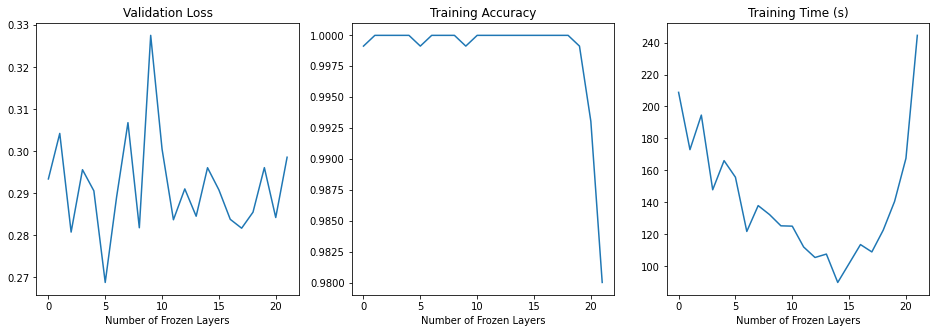

In [11]:
def grid_search(base):
  losses = []
  accuracies = []
  training_times = []
  to_freeze = []
  num_params = []
  conv_base = make_conv_base(base)
  for num_to_freeze in range(len(conv_base.layers)):
    for layer in conv_base.layers[:num_to_freeze]:
      layer.trainable = False
    model = make_model_logistic(conv_base)
    num_params.append(int(
      np.sum([K.backend.count_params(p) for p in model.trainable_weights])
    ))
    time_callback = TimeHistory()
    history = model.fit(X_train, Y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[es, time_callback],
            verbose=1,
            validation_split = 0.25)
    best_accuracy = max(history.history['accuracy'])
    best_validation_loss = min(history.history['val_loss'])
    losses.append(best_validation_loss)
    accuracies.append(best_accuracy)
    training_times.append(np.sum(time_callback.times))
    conv_base = make_conv_base(base)
    to_freeze.append(num_to_freeze)
  return losses, accuracies, training_times, to_freeze

with tf.device('/device:GPU:0'):
  losses, accuracies, training_times, to_freeze = grid_search(vgg19.VGG19)
  ig, axs = plt.subplots(1, 3, figsize=(16,5))
  axs[0].plot(to_freeze, losses)
  axs[0].title.set_text('Validation Loss')
  axs[0].set_xlabel('Number of Frozen Layers')
  axs[1].plot(to_freeze, accuracies)
  axs[1].title.set_text('Training Accuracy')
  axs[1].set_xlabel('Number of Frozen Layers')
  axs[2].plot(to_freeze, training_times)
  axs[2].title.set_text('Training Time (s)')
  axs[2].set_xlabel('Number of Frozen Layers')
  plt.savefig('6.802/vgg19_logistic_freeze_comparison.png')


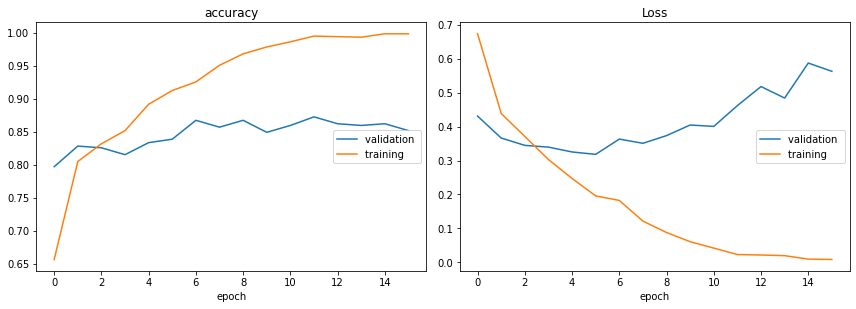

accuracy
	validation       	 (min:    0.797, max:    0.872, cur:    0.852)
	training         	 (min:    0.656, max:    0.998, cur:    0.998)
Loss
	validation       	 (min:    0.318, max:    0.587, cur:    0.563)
	training         	 (min:    0.008, max:    0.673, cur:    0.008)

Epoch 00016: val_loss did not improve from 0.31809
Epoch 00016: early stopping
385/385 [==============================] - 1s 3ms/step
number positive predictions: 110


NameError: ignored

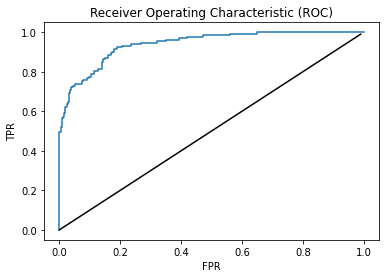

In [14]:
with tf.device('/device:GPU:0'):
  conv_base = make_conv_base(vgg19.VGG19)
  for layer in conv_base.layers[:5]:
    layer.trainable = False
  model = make_model_logistic(conv_base)
  time_callback = TimeHistory()
  train_model(model, X_train, Y_train, [time_callback, checkpointer])
  model.load_weights('weights.hdf5')
  Y_pred, evaluation, prediction_time = evaluate_model(model, X_test, Y_test)
  print('number positive predictions:', np.sum(1-np.argmax(Y_pred,axis=1)))
  auc = roc_auc_score(Y_test, Y_pred)
  fpr, tpr, thresholds = roc_curve(Y_test[:,0], Y_pred[:,0])
  plt.plot(fpr, tpr)
  plt.plot([i/100 for i in range(100)], [i/100 for i in range(100)], color='black')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.savefig('6.802/{}roc.png'.format('vgg19_frozen_roc'))
  print('AUC ROC:', auc)
  print('loss:', evaluation[0])
  print('accuracy:', evaluation[1])
  print('training time:', np.sum(time_callback.times))
  print('prediction time:', prediction_time)

In [15]:
plt.savefig('6.802/{}roc.png'.format('vgg19_frozen_roc.png'))

<Figure size 432x288 with 0 Axes>

## Training and Evaluation (multi-class classification)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

raw_X = np.load('gdrive/My Drive/6.802/data.npy')
raw_Y_multiclass = np.load('gdrive/My Drive/6.802/labels_multiclass.npy')

print('Loaded pre-processed multi-class data from Google Drive.')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loaded pre-processed multi-class data from Google Drive.


In [6]:
lb_multi = preprocessing.LabelBinarizer()
lb_multi.fit([value for value in scoring_encoding.values()])
binarized_labels_multiclass = lb_multi.transform(raw_Y_multiclass)

X, Y_multiclass = shuffle(raw_X, binarized_labels_multiclass)
X_positive = X[raw_Y_multiclass!=0]
Y_positive = Y_multiclass[raw_Y_multiclass!=0]
assert X_positive.shape[0] == Y_positive.shape[0]

X_train, X_test, Y_multiclass_train, Y_multiclass_test = train_test_split(X, Y_multiclass, test_size = 0.2)
X_positive_train, X_positive_test, Y_positive_train, Y_positive_test = train_test_split(X_positive, Y_positive, test_size = 0.2)

print('Split data into train and test sets.')

Split data into train and test sets.


In [7]:
def make_model_multiclass(conv_base, dropout_rate, learning_rate):
  model = K.models.Sequential()
  model.add(conv_base)
  model.add(K.layers.Flatten())
  model.add(K.layers.Dense(1024, activation='relu'))
  model.add(K.layers.Dropout(dropout_rate))
  model.add(K.layers.Dense(len([score for score in scoring_encoding.values()]), activation='softmax'))
  model.summary()

  model.compile(optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  return model

dropout_rates = [0.1, 0.3, 0.5, 0.7]
learning_rates = [10e-2, 10e-4, 10e-6, 10e-8]

def make_model_positive(conv_base, dropout_rate, learning_rate):
  model = K.models.Sequential()
  model.add(conv_base)
  model.add(K.layers.Flatten())
  model.add(K.layers.Dense(1024, activation='relu'))
  model.add(K.layers.Dropout(dropout_rate))
  model.add(K.layers.Dense(len([score for score in scoring_encoding.values()]-1), activation='softmax'))
  model.summary()

  model.compile(optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
  return model

def grid_search_multiclass(base, x_train, y_train):
  result = {}
  heatmap_accuracy = []
  heatmap_loss = []
  conv_base = make_conv_base(base)
  for layer in conv_base.layers[:5]:
    layer.trainable = False
  for dropout_rate in dropout_rates:
    for learning_rate in learning_rates:
      heatmap_accuracy_internal = []
      heatmap_loss_internal = []
      model = make_model_multiclass(conv_base, dropout_rate, learning_rate)
      time_callback = TimeHistory()
      history = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              callbacks=[es, time_callback],
              verbose=1,
              validation_split = 0.25)
      best_accuracy = max(history.history['accuracy'])
      best_validation_loss = min(history.history['val_loss'])
      heatmap_accuracy_internal.append(best_accuracy)
      heatmap_loss_internal.append(best_validation_loss)
      result[(dropout_rate, learning_rate)] = (best_validation_loss, best_accuracy, np.sum(time_callback.times))
      conv_base = make_conv_base(base)
      for layer in conv_base.layers[:5]:
        layer.trainable = False
    heatmap_accuracy.append(heatmap_accuracy_internal)
    heatmap_loss.append(heatmap_loss_internal)
  return result, np.array(heatmap_accuracy), np.array(heatmap_loss)

with tf.device('/device:GPU:0'):
  print('VGG19, multiclass classifier')
  result_vgg19, heatmap_accuracy_vgg19, heatmap_loss_vgg19 = grid_search_multiclass(vgg19.VGG19, X_train, Y_multiclass_train)
  # print('VGG19, positive classifier')
  # result_vgg19, heatmap_accuracy_vgg19, heatmap_loss_vgg19 = grid_search_multiclass(vgg19.VGG19, X_positive_train, Y_positive_train)
  # print('nasnetmobile, multiclass classifier')
  # result_nasnetmobile = grid_search_multiclass(nasnet.NASNetMobile)
  # print(max(result.keys(), key= lambda x: result[x][1]))
  #get_results_for_model(vgg19_base, make_model_multiclass, 'vgg19_multiclass', multiclass=True)

VGG19, multiclass classifier
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 8200      
Total params: 45,723,720
Trainable params: 45,611,144
Non-trainable params: 112,576
_________________________________________________________________
Train on 1152 samples, validate on 384 samples
Epoch 1/100
1152/1152 [===

https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

{(0.1, 0.1): (4.441134407888958e+28, 0.090277776, 107.0249240398407), (0.1, 0.001): (242160304128.0, 0.060763888, 95.12509655952454), (0.1, 1e-05): (0.7229830970366796, 0.11805555, 95.1922664642334), (0.1, 1e-07): (0.6487157344818115, 0.23697917, 361.9383502006531), (0.3, 0.1): (8.739559687726677e+28, 0.051215276, 95.11941576004028), (0.3, 0.001): (29993867.666666668, 0.078125, 95.15478754043579), (0.3, 1e-05): (0.6405117710431417, 0.114583336, 95.34840941429138), (0.3, 1e-07): (0.6504479050636292, 0.10763889, 457.7428946495056), (0.5, 0.1): (4.499720912889574e+28, 0.090277776, 95.41676473617554), (0.5, 0.001): (31648617157973.332, 0.075520836, 95.65843629837036), (0.5, 1e-05): (0.6733646591504415, 0.12847222, 95.76030087471008), (0.5, 1e-07): (0.6692565679550171, 0.14149305, 477.3529326915741), (0.7, 0.1): (7.114499769893972e+27, 0.09201389, 95.73676061630249), (0.7, 0.001): (6524394837.333333, 0.10329861, 95.87122011184692), (0.7, 1e-05): (0.6536648472150167, 0.12586805, 95.895316839

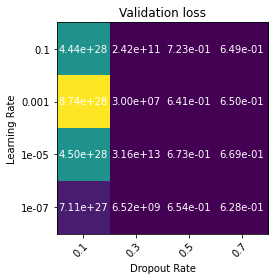

In [12]:
# ig, axs = plt.subplots(2,2)
# axs[0,0].imshow(X[0])
# axs[0,1].imshow(X[1])
# axs[1,0].imshow(X[2])
# axs[1,1].imshow(X[3])
# print(Y[:4])
# plt.savefig('6.802/patch_examples.png')
# patient_image = pydicom.dcmread('/inbreast/dicom/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm').pixel_array
# plt.imshow(patient_image, cmap='bone')
# plt.scatter([3259], [3044], color='red')
# print(inbreast_rois['20586908'])
# plt.savefig('6.802/inbreast_example.png')
# print(X_test.shape)
# print(to_freeze[np.argmin(losses)])
# print(len(to_freeze))
# os.chdir('../..')
# !pwd

#K.utils.plot_model(make_model_multiclass(vgg19.VGG19), to_file='model.png')
heatmap_accuracy = []
heatmap_loss = []
for dropout_rate in dropout_rates:
  heatmap_accuracy_internal = []
  heatmap_loss_internal = []
  for learning_rate in learning_rates:
    heatmap_accuracy_internal.append(result_vgg19[(dropout_rate, learning_rate)][1])
    heatmap_loss_internal.append(result_vgg19[(dropout_rate, learning_rate)][0])
  heatmap_accuracy.append(heatmap_accuracy_internal)
  heatmap_loss.append(heatmap_loss_internal)
print(result_vgg19)

# print(result_vgg19[max(result_vgg19.keys(), key= lambda x: result_vgg19[x][1])])

def plot_heatmap(heatmap):
  fig, ax = plt.subplots()
  im = ax.imshow(heatmap)

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(dropout_rates)))
  ax.set_yticks(np.arange(len(learning_rates)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(dropout_rates)
  ax.set_yticklabels(learning_rates)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(dropout_rates)):
      for j in range(len(learning_rates)):
          text = ax.text(j, i, "{:.2e}".format(heatmap[i, j]),
                        ha="center", va="center", color="w")
  ax.set_xlabel('Dropout Rate')
  ax.set_ylabel('Learning Rate')
  ax.set_title("Validation loss")
  fig.tight_layout()
  plt.savefig('gdrive/My Drive/6.802/validation_loss_heatmap.png')

print(heatmap_loss)
plot_heatmap(np.array(heatmap_loss))

In [35]:
print(Y_multiclass!=0)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ...  True False False]
 [False False False ... False False False]]
